# Direct Collocation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import MX, DM, Function
import casadi as cas
from platform import python_version
from numpy.testing import assert_array_equal, assert_array_almost_equal

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.7
Python: 3.10.16


Verify that the reference file runs successfully.


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3528
Number of nonzeros in inequality constraint Jacobian.:      328
Number of nonzeros in Lagrangian Hessian.............:     2217

Total number of variables............................:      409
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      328
Total number of inequality c

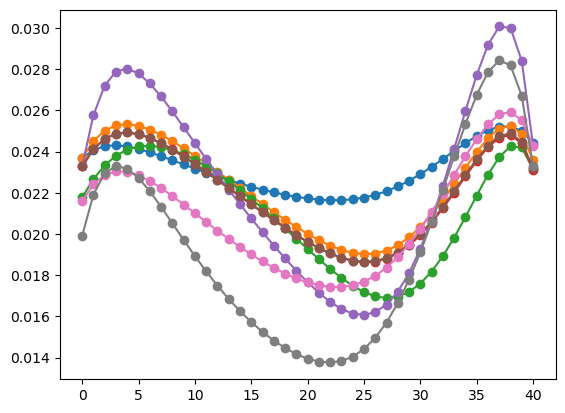

In [2]:
%run "sparse_system.py"

## 1. Direct Collocation

### 1.1 Timing information of IPOPT

Note down the timing information of IPOPT: `Total CPU secs in IPOPT (w/o function
evaluations)` and `Total CPU secs in NLP function evaluations`